In [19]:
import pybbn
import pandas as pd
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx 
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys
import os

from utils_sys import Printer

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.sampling.sampling import LogicSampler

from scipy.stats import binom
import numpy as np
np.seterr(invalid='ignore')
import plotly
import plotly.io as pio
import chart_studio
import chart_studio.plotly as cspy
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from urllib.request import urlopen
import json
import random

import seaborn as sns 

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

username = 'vishalgattani' # your username\n",
api_key = 'WSy2EFPTbxYYm3Rmcx53' # your api key - go to profile > settings > regenerate key\n",
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)


def getBinomProb(total_exp_runs,p):
    return list(binom.pmf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def getCDFBinomProb(total_exp_runs,p):
    return list(binom.cdf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def evidence(join_tree,ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
def resetEvidence(join_tree):
    join_tree.unobserve_all()
    
def print_probs(join_tree):
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node.to_dict())
        print("Values:")
        print(potential)
        print('----------------')
        
    print("="*90)
        
def print_probs_node(join_tree,id):
    for node in join_tree.get_bbn_nodes():
        if (node.to_dict()['variable']['id']==id):
            # Printer.green("Node:",node.variable.name)
            potential = join_tree.get_bbn_potential(node)
            df = potential_to_df(join_tree.get_bbn_potential(node))
#             display(df)
            return df
            
def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        display(df)
        t = (name, df)
        data.append(t)
    return data

def drawBBN(bbn):
    n, d = bbn.to_nx_graph()
    pos = nx.spring_layout(n)
    nx.draw_spring(n, with_labels=True,labels=d)
    ax = plt.gca()
    
    plt.show()

def plotROC(p,r,fpr_tree, tpr_tree,fpr_lr, tpr_lr,fpr_lrl2, tpr_lrl2,fpr_nb, tpr_nb):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr_tree, y=tpr_tree, mode="markers+lines",name='DT'))
    fig.add_trace(go.Scatter(x=fpr_lr, y=tpr_lr, mode="markers+lines",name='LR'))
    fig.add_trace(go.Scatter(x=fpr_lrl2, y=tpr_lrl2, mode="markers+lines",name='LR(L2)'))
#     fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode="markers+lines",name='NB'))
    fig.update_layout(hovermode="x",title='Receiver Operating Characteristic '+"p="+str(p)+",r="+str(r))
    fig.update_xaxes(title_text='TPR')
    fig.update_yaxes(title_text='FPR')
    fig.show()
    
def getFPTN(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'False', 1.0)
    df = print_probs_node(join_tree)
    resetEvidence(join_tree,0)
    dffp = df[df['val']=='Correct']['p']
    dftn = df[df['val']=='Incorrect']['p']
    return dffp,dftn
    
def getFNTP(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
    df = print_probs_node(join_tree,0)
    resetEvidence(join_tree)
    dffn = df[df['val']=='Incorrect']['p']
    dftp = df[df['val']=='Correct']['p']
    return dffn,dftp

In [ ]:

# variables
n_runs = 10
threshold_num_runs = 1 # number of times MR is better than AA in time
p_t = 0.5 # probability of MR being better than AA in time
ps_mr = 0.8 # probability that the MR succeeds in a run (ps_mr)
ps_a = 0.5 # probability that the A succeeds in a run (ps_a)

p_t_list = [0.4]
ps_mr_list = [0.75]
ps_a_list = [0.6]

simulation_data = []

for total_exp_runs in range(2,n_runs+1):
    for p_t in p_t_list:
        for ps_mr in ps_mr_list:
            for ps_a in ps_a_list:
                for threshold_num_runs in range(0,total_exp_runs+1):
                    
                    
                    sr_mr = getBinomProb(total_exp_runs,ps_mr)
                    # print(sr_mr)
                    sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                    # display(sr_mr_cpt)

                    sr_a = getBinomProb(total_exp_runs,ps_a)
                    # print(sr_a)
                    sr_a_cpt = pd.DataFrame({"success":sr_a})
                    # display(sr_a_cpt)

        
                    vals = []
                    mr_dec_ts_keys = []
                    mr_dec_ts_values = []
                    mrp_successes = []
                    a_successes = []
                    test_values = []
                    for i in range(total_exp_runs+1):
                        for k in range(total_exp_runs+1):
                            mrp_successes.append(str(i))
                        for j in range(total_exp_runs+1):
                            a_successes.append(str(j))
                            if i > j:
                                test_values.append([1,0])
                            else:
                                test_values.append([0,1])
                        
                        mr_dec_ts_keys.append(str(i))
                        if i >= threshold_num_runs:
                            mr_dec_ts_values.append([1,0])
                        else:
                            mr_dec_ts_values.append([0,1])
                            
                    mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                    mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                    mr_dec_ts_cpt["States"] = ['True','False']
                    mr_dec_ts_cpt.set_index("States",inplace=True)

                    for i in range(len(mrp_successes)):
                        vals.append([test_values[i][0],test_values[i][1]])
                    new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                    new_df = new_df.transpose()
                    
                    ts_mr_better = getBinomProb(total_exp_runs,p_t)
                    ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                    
                    # define nodes, states, cpt
                    mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                        ["True","False"]),
                                        [1,0,0,1,0,1,0,1])

                    mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                        new_df.index.values.tolist()),
                                        np.ndarray.flatten(new_df.transpose().values).tolist())

                    mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_mr)

                    aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_a)

                    mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                        mr_dec_ts_cpt.index.values.tolist()), 
                                        np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                    mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                    bbn = Bbn() \
                        .add_node(mr_imp_perf) \
                        .add_node(mr_inc_sr) \
                        .add_node(mr_sr_ev) \
                        .add_node(aa_sr_ev) \
                        .add_node(mr_ts_ev) \
                        .add_node(mr_dec_ts) \
                        .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                        

                    join_tree = InferenceController.apply(bbn)

                    # drawBBN(bbn)  

                    topclaim_df = print_probs_node(join_tree,0)
                    topclaim_df.p = topclaim_df.p.round(4)
                    
                    mr_increases_sr = print_probs_node(join_tree,1)
                    mr_increases_sr.p = mr_increases_sr.p.round(4)
                    # display(mr_increases_sr)
                    mr_decreases_ts = print_probs_node(join_tree,4)
                    mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                    # display(mr_decreases_ts)

                    data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                            mr_increases_sr.p[0],mr_increases_sr.p[1],
                            mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                            topclaim_df.p[0],topclaim_df.p[1]]
                    # Printer.orange(data)
                    simulation_data.append(data)
                    
                    

df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
# display(df) 
# df["linear_yes"] = df["mr_yes"].diff()
# df["linear_no"] = df["mr_no"].diff()

dfs = df.groupby(['n_exp','pt','p1','p2'])
# fig = go.Figure()
best_dfs = []

for i in dfs:
    
    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    display(i[1])
    exps = i[1].n_exp.values.tolist()
    nt = i[1].threshold_nt.values.tolist()
    
    # Define x labels and corresponding probabilities of true and false
    x_labels = []
    for c in range(len(exps)):
        lab = f"{exps[c]},{nt[c]}"
        x_labels.append(lab)
    
    # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
    true_probs = i[1].mr_yes.values.tolist()
    false_probs = i[1].mr_no.values.tolist()
    # Set width of bars
    bar_width = 0.35

    # Set x positions of bars
    x_pos = np.arange(len(x_labels))*2

    # Plot the bars
    fig, ax = plt.subplots()
    true_bars = ax.bar(x_pos, true_probs, bar_width, color='g', label='True')
    false_bars = ax.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

    # Add labels and title
    ax.set_xlabel('Number of Experiments (n), Threshold of times MR is better (Nt)')
    ax.set_ylabel('Probabilities')
    ax.set_title('Probabilities of True and False for Multiple X Labels')
    ax.set_xticks(x_pos + bar_width / 2)
    ax.set_xticklabels(x_labels)

    # Add legend
    ax.legend()
    plt.tight_layout()
    # Show the plot
    plt.show()
    

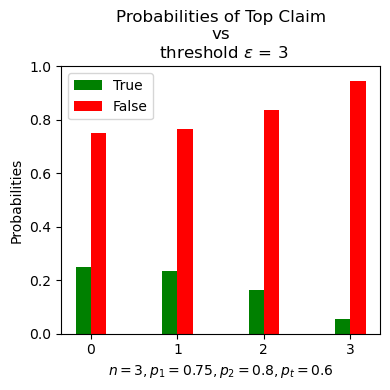

0.2509 0.7491


In [20]:


def BBN_belief(n,nt,psmr,psa,pt,show=False):

    # variables
    n_runs = n
    # threshold_num_runs = nt # number of times MR is better than AA in time
    # p_t = probability of MR being better than AA in time
    # ps_mr = probability that the MR succeeds in a run (ps_mr)
    # ps_a = probability that the A succeeds in a run (ps_a)

    p_t_list = pt
    ps_mr_list = psmr
    ps_a_list = psa

    simulation_data = []

    for total_exp_runs in range(n,n_runs+1):
        for p_t in p_t_list:
            for ps_mr in ps_mr_list:
                for ps_a in ps_a_list:
                    for threshold_num_runs in range(0,nt+1):
                        
                        
                        sr_mr = getBinomProb(total_exp_runs,ps_mr)
                        # print(sr_mr)
                        sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                        x = sr_mr_cpt
                        idxlist = sr_mr_cpt.index.tolist()
                        sr_mr_cpt = sr_mr_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        

                        sr_a = getBinomProb(total_exp_runs,ps_a)
                        # print(sr_a)
                        sr_a_cpt = pd.DataFrame({"success":sr_a})
                        y = sr_a_cpt
                        idxlist = sr_a_cpt.index.tolist()
                        sr_a_cpt = sr_a_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        
            
                        vals = []
                        mr_dec_ts_keys = []
                        mr_dec_ts_values = []
                        mrp_successes = []
                        a_successes = []
                        test_values = []
                        for i in range(total_exp_runs+1):
                            for k in range(total_exp_runs+1):
                                mrp_successes.append(str(i))
                            for j in range(total_exp_runs+1):
                                a_successes.append(str(j))
                                if i > j:
                                    test_values.append([1,0])
                                else:
                                    test_values.append([0,1])
                            
                            mr_dec_ts_keys.append(str(i))
                            if i >= threshold_num_runs:
                                mr_dec_ts_values.append([1,0])
                            else:
                                mr_dec_ts_values.append([0,1])
                                
                        mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                        mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                        mr_dec_ts_cpt["States"] = ['True','False']
                        mr_dec_ts_cpt.set_index("States",inplace=True)
                        
                        # Printer.cyan("mrdecreases")
                        # display(mr_dec_ts_cpt)

                        for i in range(len(mrp_successes)):
                            vals.append([test_values[i][0],test_values[i][1]])
                        new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                        new_df = new_df.transpose()
                        
                        # display(new_df)
                        
                        ts_mr_better = getBinomProb(total_exp_runs,p_t)
                        checkdf = getCDFBinomProb(total_exp_runs,p_t)
                        ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                        z = ts_mr_better_cpt
                        idxlist = ts_mr_better_cpt.index.tolist()
                        ts_mr_better_cpt = ts_mr_better_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        
                        
                        # define nodes, states, cpt
                        mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                            ["True","False"]),
                                            [1,0,0,1,0,1,0,1])

                        mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                            new_df.index.values.tolist()),
                                            np.ndarray.flatten(new_df.transpose().values).tolist())

                        mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            sr_mr)

                        aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            sr_a)

                        mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                            mr_dec_ts_cpt.index.values.tolist()), 
                                            np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                        mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                        bbn = Bbn() \
                            .add_node(mr_imp_perf) \
                            .add_node(mr_inc_sr) \
                            .add_node(mr_sr_ev) \
                            .add_node(aa_sr_ev) \
                            .add_node(mr_ts_ev) \
                            .add_node(mr_dec_ts) \
                            .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                            .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                            

                        join_tree = InferenceController.apply(bbn)
                            

                        topclaim_df = print_probs_node(join_tree,0)
                        topclaim_df.p = topclaim_df.p.round(4)
                        
                        mr_increases_sr = print_probs_node(join_tree,1)
                        mr_increases_sr.p = mr_increases_sr.p.round(4)
                        # display(mr_increases_sr)
                        mr_decreases_ts = print_probs_node(join_tree,4)
                        mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                        # display(mr_decreases_ts)
                        
                        
                        # # drawBBN(bbn)  
                        # # for i in range(6):
                        checkdf = print_probs_node(join_tree,5)
                        
                        ll = []
                        for i in range(len(checkdf)):
                            l =  checkdf.p.iloc[i:].values.tolist()
                            ll.append(np.round(sum(l),3))
                            
                        checkdf['P'] = ll
                        
                        
                        if show:
                            height = checkdf.P.values.tolist()
                            bars = checkdf.val.values.tolist()
                            x_pos = np.arange(len(bars))
                    
                            # Create bars with different colors
                            plt.bar(x_pos, height, label=bars)
                            plt.xticks(x_pos, bars)
                            plt.ylabel("P($X_{MRNT} \geq \epsilon$)")
                            plt.xlabel("$\epsilon$")
                            plt.title("P($X_{MRNT}$)" + f"\n n={total_exp_runs}, $p_1$={ps_mr}, $p_2$={ps_a}, $p_t$={p_t}")
                            # plt.legend()
                            plt.show()
                            
                            height = mr_decreases_ts.p.values.tolist()
                            bars = mr_decreases_ts.val.values.tolist()
                            x_pos = np.arange(len(bars))
                    
                            # Create bars with different colors
                            plt.bar(x_pos, height, label=bars)
                            plt.xticks(x_pos, bars)
                            plt.ylabel("P($X_{MRTS} \geq$ "+str(threshold_num_runs)+")")
                            plt.xlabel("$\epsilon$")
                            plt.title("P($X_{MRTS}$)" + f"\n n={total_exp_runs},$n_t$={threshold_num_runs}, $p_1$={ps_mr}, $p_2$={ps_a}, $p_t$={p_t}")
                            # plt.legend()
                            plt.ylim([0.0,1.0])
                            fig = plt.gcf()
                            plt.tight_layout()
                            plt.show()
                            fname = f"meta/pmrts-n-{total_exp_runs}-nt-{threshold_num_runs}-p1-{ps_mr}-p2-{ps_a}-pt-{p_t}.png"
                            fig.savefig(fname, dpi=300)
                            
                        

                        data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                                mr_increases_sr.p[0],mr_increases_sr.p[1],
                                mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                                topclaim_df.p[0],topclaim_df.p[1]]
                        # Printer.orange(data)
                        simulation_data.append(data)
                        
                        if show:
                            Printer.green("mrsr")
                            x.success = x.success.round(4)
                            display(x)
                            display(sr_mr_cpt)
                            Printer.green("asr")
                            y.success = y.success.round(4)
                            display(y)
                            display(sr_a_cpt)
                            Printer.green("mrts")
                            z.success = z.success.round(4)
                            display(z)
                            display(ts_mr_better_cpt)

                        

    df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
    if show:
        display(df)
        
    dfs = df.groupby(['n_exp','pt','p1','p2'])
    # fig = go.Figure()
    best_dfs = []

    plotno=1
    cols1 = len(ps_mr_list)
    cols2 = len(ps_a_list)
    cols3 = len(pt)
    cols = max([cols1,cols2,cols3])
    # cols = cols1*cols2*cols3
    # if cols1==cols2:
    #     cols=cols1
    rows = len(df.n_exp.unique().tolist())
    # fig, ax = plt.subplots(rows,cols)
    plt.figure(figsize=(4*cols,4*rows))
    
    
    for i in dfs:

    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
    #     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
        exps = i[1].n_exp.values.tolist()
        nt = i[1].threshold_nt.values.tolist()
        p1 = i[1].p1.values.tolist()
        p2 = i[1].p2.values.tolist()
        pt = i[1].pt.unique().tolist()[0]


        # Define x labels and corresponding probabilities of true and false
        x_labels = []
        for c in range(len(exps)):
            lab = f"{nt[c]}"
            x_labels.append(lab)

        # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
        true_probs = i[1].mr_yes.values.tolist()
        false_probs = i[1].mr_no.values.tolist()
        # Set width of bars
        bar_width = 0.35

        # Set x positions of bars
        x_pos = np.arange(len(x_labels))*2
        # Plot the bars

        plt.subplot(rows,cols,plotno)
        true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
        false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

        # Add labels and title
        plt.xlabel(f"$n={n},p_1={p1[0]},p_2={p2[0]},p_t={pt}$")
        plt.ylabel('Probabilities')
        plt.title(f'Probabilities of Top Claim\nvs\n threshold $\epsilon$ = {nt[-1]}')
        # plt.ticks(x_pos + bar_width / 2)
        plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
        plt.ylim([0.0,1.0])

        # Add legend
        plt.legend()
        plt.tight_layout()
        # Show the plot
        plotno+=1

    plt.show()
    T = df.mr_yes.values.tolist()[0]
    F = df.mr_no.values.tolist()[0]
     
    return df,T,F






# df,t,f = BBN_belief(3,3,[0.8],[0.75],[0.6])
# print(t,f)


df,t,f = BBN_belief(3,3,[0.75],[0.8],[0.6])
print(t,f)

In [21]:
def BBN_plotall(n,psmr,psa,pt,path,show=False):
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path)

    # variables
    n_runs = n
    # threshold_num_runs = nt # number of times MR is better than AA in time
    # p_t = probability of MR being better than AA in time
    # ps_mr = probability that the MR succeeds in a run (ps_mr)
    # ps_a = probability that the A succeeds in a run (ps_a)

    p_t_list = pt
    ps_mr_list = psmr
    ps_a_list = psa

    simulation_data = []

    for total_exp_runs in range(1,n_runs+1):
        for p_t in p_t_list:
            for ps_mr in ps_mr_list:
                for ps_a in ps_a_list:
                    for threshold_num_runs in range(0,total_exp_runs+1):
                        
                        
                        sr_mr = getBinomProb(total_exp_runs,ps_mr)
                        # print(sr_mr)
                        sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                        x = sr_mr_cpt
                        idxlist = sr_mr_cpt.index.tolist()
                        sr_mr_cpt = sr_mr_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        

                        sr_a = getBinomProb(total_exp_runs,ps_a)
                        # print(sr_a)
                        sr_a_cpt = pd.DataFrame({"success":sr_a})
                        y = sr_a_cpt
                        idxlist = sr_a_cpt.index.tolist()
                        sr_a_cpt = sr_a_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        
            
                        vals = []
                        mr_dec_ts_keys = []
                        mr_dec_ts_values = []
                        mrp_successes = []
                        a_successes = []
                        test_values = []
                        for i in range(total_exp_runs+1):
                            for k in range(total_exp_runs+1):
                                mrp_successes.append(str(i))
                            for j in range(total_exp_runs+1):
                                a_successes.append(str(j))
                                if i > j:
                                    test_values.append([1,0])
                                else:
                                    test_values.append([0,1])
                            
                            mr_dec_ts_keys.append(str(i))
                            if i >= threshold_num_runs:
                                mr_dec_ts_values.append([1,0])
                            else:
                                mr_dec_ts_values.append([0,1])
                                
                        mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                        mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                        mr_dec_ts_cpt["States"] = ['True','False']
                        mr_dec_ts_cpt.set_index("States",inplace=True)

                        for i in range(len(mrp_successes)):
                            vals.append([test_values[i][0],test_values[i][1]])
                        new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                        new_df = new_df.transpose()
                        
                        ts_mr_better = getBinomProb(total_exp_runs,p_t)
                        ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                        z = ts_mr_better_cpt
                        idxlist = ts_mr_better_cpt.index.tolist()
                        ts_mr_better_cpt = ts_mr_better_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        
                        
                        # define nodes, states, cpt
                        mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                            ["True","False"]),
                                            [1,0,0,1,0,1,0,1])

                        mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                            new_df.index.values.tolist()),
                                            np.ndarray.flatten(new_df.transpose().values).tolist())

                        mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            sr_mr)

                        aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            sr_a)

                        mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                            mr_dec_ts_cpt.index.values.tolist()), 
                                            np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                        mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                        bbn = Bbn() \
                            .add_node(mr_imp_perf) \
                            .add_node(mr_inc_sr) \
                            .add_node(mr_sr_ev) \
                            .add_node(aa_sr_ev) \
                            .add_node(mr_ts_ev) \
                            .add_node(mr_dec_ts) \
                            .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                            .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                            

                        join_tree = InferenceController.apply(bbn)

                        # drawBBN(bbn)  

                        topclaim_df = print_probs_node(join_tree,0)
                        topclaim_df.p = topclaim_df.p.round(4)
                        
                        mr_increases_sr = print_probs_node(join_tree,1)
                        mr_increases_sr.p = mr_increases_sr.p.round(4)
                        # display(mr_increases_sr)
                        mr_decreases_ts = print_probs_node(join_tree,4)
                        mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                        # display(mr_decreases_ts)

                        data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                                mr_increases_sr.p[0],mr_increases_sr.p[1],
                                mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                                topclaim_df.p[0],topclaim_df.p[1]]
                        # Printer.orange(data)
                        simulation_data.append(data)
                        
                        # if 0:
                        #     Printer.green("mrsr")
                        #     x.success = x.success.round(4)
                        #     display(x)
                        #     display(sr_mr_cpt)
                        #     Printer.green("asr")
                        #     y.success = y.success.round(4)
                        #     display(y)
                        #     display(sr_a_cpt)
                        #     Printer.green("mrts")
                        #     z.success = z.success.round(4)
                        #     display(z)
                        #     display(ts_mr_better_cpt)

                        

    df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
    
    df['claim'] = np.where(df['mr_yes'] > df['mr_no'], 1, 0)
    
    if not show:
        display(df)
        
        
        
    dfs = df.groupby(['n_exp','pt','p1','p2'])
    # fig = go.Figure()
    best_dfs = []

    
    cols1 = len(ps_mr_list)
    cols2 = len(ps_a_list)
    cols3 = len(pt)
    cols = max([cols1,cols2,cols3])
    # cols = cols1*cols2*cols3
    # if cols1==cols2:
    #     cols=cols1
    rows = len(df.n_exp.unique().tolist())
    
    # fig, ax = plt.subplots(rows,cols)
    plt.figure(figsize=(4*cols,4*rows))
    
    
    plotno=1
    for i in dfs:
        # rows = len(i[1].n_exp.unique().tolist())
        # plt.figure(figsize=(4,4))

    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
    #     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
        # display(i[1])
    
    
        exps = i[1].n_exp.values.tolist()
        n = max(i[1].n_exp.unique().tolist())
        nt = i[1].threshold_nt.values.tolist()
        p1 = i[1].p1.values.tolist()
        p2 = i[1].p2.values.tolist()
        pt = i[1].pt.unique().tolist()[0]


        # Define x labels and corresponding probabilities of true and false
        x_labels = []
        for c in range(len(exps)):
            lab = f"{nt[c]}"
            x_labels.append(lab)

        # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
        true_probs = i[1].mr_yes.values.tolist()
        false_probs = i[1].mr_no.values.tolist()
        # Set width of bars
        bar_width = 0.35

        # Set x positions of bars
        x_pos = np.arange(len(x_labels))*2
        # Plot the bars

        
        
        plt.subplot(rows,cols,plotno)
        true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
        false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

        # Add labels and title
        plt.xlabel(f"$p_1={p1[0]},p_2={p2[0]},p_t={pt}$")
        plt.ylabel('Probabilities')
        plt.title(f'Probabilities of Top Claim\nn={exps[0]}\n$\epsilon$ = {{{0},$...$,{nt[-1]}}}')
        # plt.ticks(x_pos + bar_width / 2)
        plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
        plt.ylim([0.0,1.0])

        # Add legend
        plt.legend(loc="upper right")
        plt.tight_layout()
        # Show the plot
        plotno+=1
        
    p1 = df.p1.unique().tolist()
    p2 = df.p2.unique().tolist()
    pt = df.pt.unique().tolist()
        
    fig = plt.gcf()
    plt.tight_layout()
    plt.show()
    case = path.split("/")[1]
    fname = f"{path}/{case}-all-n-{n}-p1-{p1}-p2-{p2}-pt-{pt}.png"
    fig.savefig(fname, dpi=300)
    # plt.show()
     
    return df




In [22]:
def BBN(n,psmr,psa,pt,path,show=False):
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path)

    # variables
    n_runs = n
    # threshold_num_runs = nt # number of times MR is better than AA in time
    # p_t = probability of MR being better than AA in time
    # ps_mr = probability that the MR succeeds in a run (ps_mr)
    # ps_a = probability that the A succeeds in a run (ps_a)

    p_t_list = pt
    ps_mr_list = psmr
    ps_a_list = psa

    simulation_data = []

    for total_exp_runs in range(1,n_runs+1):
        for p_t in p_t_list:
            for ps_mr in ps_mr_list:
                for ps_a in ps_a_list:
                    for threshold_num_runs in range(0,total_exp_runs+1):
                        
                        
                        sr_mr = getBinomProb(total_exp_runs,ps_mr)
                        # print(sr_mr)
                        sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                        x = sr_mr_cpt
                        idxlist = sr_mr_cpt.index.tolist()
                        sr_mr_cpt = sr_mr_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        

                        sr_a = getBinomProb(total_exp_runs,ps_a)
                        # print(sr_a)
                        sr_a_cpt = pd.DataFrame({"success":sr_a})
                        y = sr_a_cpt
                        idxlist = sr_a_cpt.index.tolist()
                        sr_a_cpt = sr_a_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        
            
                        vals = []
                        mr_dec_ts_keys = []
                        mr_dec_ts_values = []
                        mrp_successes = []
                        a_successes = []
                        test_values = []
                        for i in range(total_exp_runs+1):
                            for k in range(total_exp_runs+1):
                                mrp_successes.append(str(i))
                            for j in range(total_exp_runs+1):
                                a_successes.append(str(j))
                                if i > j:
                                    test_values.append([1,0])
                                else:
                                    test_values.append([0,1])
                            
                            mr_dec_ts_keys.append(str(i))
                            if i >= threshold_num_runs:
                                mr_dec_ts_values.append([1,0])
                            else:
                                mr_dec_ts_values.append([0,1])
                                
                        mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                        mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                        mr_dec_ts_cpt["States"] = ['True','False']
                        mr_dec_ts_cpt.set_index("States",inplace=True)

                        for i in range(len(mrp_successes)):
                            vals.append([test_values[i][0],test_values[i][1]])
                        new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                        new_df = new_df.transpose()
                        
                        ts_mr_better = getBinomProb(total_exp_runs,p_t)
                        ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                        z = ts_mr_better_cpt
                        idxlist = ts_mr_better_cpt.index.tolist()
                        ts_mr_better_cpt = ts_mr_better_cpt.set_index([pd.Index(["n"+str(idx) for idx in idxlist])])
                        
                        
                        # define nodes, states, cpt
                        mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                            ["True","False"]),
                                            [1,0,0,1,0,1,0,1])

                        mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                            new_df.index.values.tolist()),
                                            np.ndarray.flatten(new_df.transpose().values).tolist())

                        mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            sr_mr)

                        aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            sr_a)

                        mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                            mr_dec_ts_cpt.index.values.tolist()), 
                                            np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                        mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                            [str(i) for i in range(total_exp_runs+1)]),
                                            np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                        bbn = Bbn() \
                            .add_node(mr_imp_perf) \
                            .add_node(mr_inc_sr) \
                            .add_node(mr_sr_ev) \
                            .add_node(aa_sr_ev) \
                            .add_node(mr_ts_ev) \
                            .add_node(mr_dec_ts) \
                            .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                            .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                            .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                            

                        join_tree = InferenceController.apply(bbn)

                        # drawBBN(bbn)  

                        topclaim_df = print_probs_node(join_tree,0)
                        topclaim_df.p = topclaim_df.p.round(4)
                        
                        mr_increases_sr = print_probs_node(join_tree,1)
                        mr_increases_sr.p = mr_increases_sr.p.round(4)
                        # display(mr_increases_sr)
                        mr_decreases_ts = print_probs_node(join_tree,4)
                        mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                        # display(mr_decreases_ts)

                        data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                                mr_increases_sr.p[0],mr_increases_sr.p[1],
                                mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                                topclaim_df.p[0],topclaim_df.p[1]]
                        # Printer.orange(data)
                        simulation_data.append(data)
                        
                        # if 0:
                        #     Printer.green("mrsr")
                        #     x.success = x.success.round(4)
                        #     display(x)
                        #     display(sr_mr_cpt)
                        #     Printer.green("asr")
                        #     y.success = y.success.round(4)
                        #     display(y)
                        #     display(sr_a_cpt)
                        #     Printer.green("mrts")
                        #     z.success = z.success.round(4)
                        #     display(z)
                        #     display(ts_mr_better_cpt)

                        

    df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
    
    df['claim'] = np.where(df['mr_yes'] > df['mr_no'], 1, 0)
    
    if show:
        display(df)
        
        
        
    dfs = df.groupby(['n_exp','pt','p1','p2'])
    # fig = go.Figure()
    best_dfs = []

    
    cols1 = len(ps_mr_list)
    cols2 = len(ps_a_list)
    cols3 = len(pt)
    cols = max([cols1,cols2,cols3])
    # cols = cols1*cols2*cols3
    # if cols1==cols2:
    #     cols=cols1
    rows = len(df.n_exp.unique().tolist())
    
    # fig, ax = plt.subplots(rows,cols)
    # plt.figure(figsize=(4*cols,4*rows))
    
    
    plotno=1
    for i in dfs:
        rows = len(i[1].n_exp.unique().tolist())
        plt.figure(figsize=(4,4))

    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
    #     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
        display(i[1])
    
    
        exps = i[1].n_exp.values.tolist()
        n = i[1].n_exp.unique().tolist()[0]
        nt = i[1].threshold_nt.values.tolist()
        p1 = i[1].p1.values.tolist()
        p2 = i[1].p2.values.tolist()
        pt = i[1].pt.unique().tolist()[0]


        # Define x labels and corresponding probabilities of true and false
        x_labels = []
        for c in range(len(exps)):
            lab = f"{nt[c]}"
            x_labels.append(lab)

        # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
        true_probs = i[1].mr_yes.values.tolist()
        false_probs = i[1].mr_no.values.tolist()
        # Set width of bars
        bar_width = 0.35

        # Set x positions of bars
        x_pos = np.arange(len(x_labels))*2
        # Plot the bars

        
        
        # plt.subplot(rows,cols,plotno)
        true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
        false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

        # Add labels and title
        # plt.xlabel(f"$p_1={p1[0]},p_2={p2[0]},p_t={pt}$")
        plt.ylabel('Probabilities')
        plt.title(f'Probabilities of Top Claim\nn={n}\n$\epsilon$ = {{{0},$...$,{nt[-1]}}}')
        # plt.ticks(x_pos + bar_width / 2)
        plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
        plt.ylim([0.0,1.0])

        # Add legend
        plt.legend(loc="upper right")
        plt.tight_layout()
        # Show the plot
        plotno+=1
        
        fig = plt.gcf()
        plt.tight_layout()
        plt.show()
        case = path.split("/")[1]
        fname = f"{path}/{case}-n-{n}-nt-{nt[-1]}-p1-{p1[0]}-p2-{p2[0]}-pt-{pt}.png"
        fig.savefig(fname, dpi=300)

    # plt.show()
        
    
    
    

     
    return df


In [ ]:
#pt,p1,p2
#case 1: 00
df = BBN(10,[0.5,0.79],[0.8],[0.4],"meta/case1",show=False)
# df = BBN_plotall(10,[0.5,0.79],[0.8],[0.4],"meta/case1",show=True)


In [ ]:
#pt,p1,p2
#case 2: 10
df = BBN(10,[0.6,0.75,0.9],[0.5],[0.4],"meta/case2",show=False)
# df = BBN_plotall(10,[0.6,0.75,0.9],[0.5],[0.4],"meta/case2",show=True)

In [ ]:
claim_t = df[df.claim==1]
claim_t.groupby

In [ ]:

#pt,p1,p2
#case 3: 01
df = BBN(10,[0.4],[0.5],[0.6,0.75,0.9],"meta/case3",show=True)
df = BBN_plotall(10,[0.6,0.75,0.9],[0.5],[0.4],"meta/case3",show=True)

In [ ]:
#pt,p1,p2
#case 4a: 11 pt increases
df = BBN(10,[0.6,0.75,0.9],[0.5],[0.6],"meta/case4a",show=True)
df = BBN_plotall(10,[0.6,0.75,0.9],[0.5],[0.6],"meta/case4a",show=True)

In [ ]:
#pt,p1,p2
#case 4b: 11 p1 increases
# df = BBN(10,[0.6,0.75,0.9],[0.5],[0.6],"meta/case4a",show=True)
# df = BBN_plotall(10,[0.6,0.75,0.9],[0.5],[0.6],"meta/case4a",show=True)

df = BBN(10,[0.6],[0.5],[0.6,0.75,0.90],"meta/case4b",show=True)
df = BBN_plotall(10,[0.6],[0.5],[0.6,0.75,0.90],"meta/case4b",show=True)

In [ ]:
#case 1 - 00: mr is worse both ways

# variables
n_runs = 3
threshold_num_runs = 1 # number of times MR is better than AA in time
p_t = 0.4 # probability of MR being better than AA in time
ps_mr = 0.6 # probability that the MR succeeds in a run (ps_mr)
ps_a = 0.7 # probability that the A succeeds in a run (ps_a)

p_t_list = [0.4]
ps_mr_list = [0.4]
ps_a_list = [0.5]

simulation_data = []

for total_exp_runs in range(1,n_runs+1):
    for p_t in p_t_list:
        for ps_mr in ps_mr_list:
            for ps_a in ps_a_list:
                for threshold_num_runs in range(0,total_exp_runs+1):
                    
                    
                    sr_mr = getBinomProb(total_exp_runs,ps_mr)
                    # print(sr_mr)
                    sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                    # display(sr_mr_cpt)

                    sr_a = getBinomProb(total_exp_runs,ps_a)
                    # print(sr_a)
                    sr_a_cpt = pd.DataFrame({"success":sr_a})
                    # display(sr_a_cpt)

        
                    vals = []
                    mr_dec_ts_keys = []
                    mr_dec_ts_values = []
                    mrp_successes = []
                    a_successes = []
                    test_values = []
                    for i in range(total_exp_runs+1):
                        for k in range(total_exp_runs+1):
                            mrp_successes.append(str(i))
                        for j in range(total_exp_runs+1):
                            a_successes.append(str(j))
                            if i > j:
                                test_values.append([1,0])
                            else:
                                test_values.append([0,1])
                        
                        mr_dec_ts_keys.append(str(i))
                        if i >= threshold_num_runs:
                            mr_dec_ts_values.append([1,0])
                        else:
                            mr_dec_ts_values.append([0,1])
                            
                    mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                    mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                    mr_dec_ts_cpt["States"] = ['True','False']
                    mr_dec_ts_cpt.set_index("States",inplace=True)

                    for i in range(len(mrp_successes)):
                        vals.append([test_values[i][0],test_values[i][1]])
                    new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                    new_df = new_df.transpose()
                    
                    ts_mr_better = getBinomProb(total_exp_runs,p_t)
                    ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                    
                    # define nodes, states, cpt
                    mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                        ["True","False"]),
                                        [1,0,0,1,0,1,0,1])

                    mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                        new_df.index.values.tolist()),
                                        np.ndarray.flatten(new_df.transpose().values).tolist())

                    mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_mr)

                    aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_a)

                    mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                        mr_dec_ts_cpt.index.values.tolist()), 
                                        np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                    mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                    bbn = Bbn() \
                        .add_node(mr_imp_perf) \
                        .add_node(mr_inc_sr) \
                        .add_node(mr_sr_ev) \
                        .add_node(aa_sr_ev) \
                        .add_node(mr_ts_ev) \
                        .add_node(mr_dec_ts) \
                        .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                        

                    join_tree = InferenceController.apply(bbn)

                    # drawBBN(bbn)  

                    topclaim_df = print_probs_node(join_tree,0)
                    topclaim_df.p = topclaim_df.p.round(4)
                    
                    mr_increases_sr = print_probs_node(join_tree,1)
                    mr_increases_sr.p = mr_increases_sr.p.round(4)
                    # display(mr_increases_sr)
                    mr_decreases_ts = print_probs_node(join_tree,4)
                    mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                    # display(mr_decreases_ts)

                    data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                            mr_increases_sr.p[0],mr_increases_sr.p[1],
                            mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                            topclaim_df.p[0],topclaim_df.p[1]]
                    # Printer.orange(data)
                    simulation_data.append(data)
                    
                    

df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
# display(df) 
# df["linear_yes"] = df["mr_yes"].diff()
# df["linear_no"] = df["mr_no"].diff()

dfs = df.groupby(['n_exp','pt','p1','p2'])
# fig = go.Figure()
best_dfs = []

plotno=1
cols1 = len(ps_mr_list)
cols2 = len(ps_a_list)
if cols1==cols2:
    cols=cols1
rows = len(df.n_exp.unique().tolist())
# fig, ax = plt.subplots(rows,cols)
plt.figure(figsize=(4*cols,4*rows))
for i in dfs:
    
    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
    exps = i[1].n_exp.values.tolist()
    nt = i[1].threshold_nt.values.tolist()
    p1 = i[1].p1.values.tolist()
    p2 = i[1].p2.values.tolist()
    pt = i[1].pt.unique().tolist()[0]
    
    
    # Define x labels and corresponding probabilities of true and false
    x_labels = []
    for c in range(len(exps)):
        lab = f"{nt[c]}"
        x_labels.append(lab)
    
    # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
    true_probs = i[1].mr_yes.values.tolist()
    false_probs = i[1].mr_no.values.tolist()
    # Set width of bars
    bar_width = 0.35

    # Set x positions of bars
    x_pos = np.arange(len(x_labels))*2
    # Plot the bars
    
    plt.subplot(rows,cols,plotno)
    true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
    false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

    # Add labels and title
    plt.xlabel(f"p1={p1[0]},p2={p2[0]},pt={pt}")
    plt.ylabel('Probabilities')
    plt.title('Probabilities of Top Claim being True/False')
    # plt.ticks(x_pos + bar_width / 2)
    plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
    plt.ylim([0.0,1.0])

    # Add legend
    plt.legend()
    plt.tight_layout()
    # Show the plot
    plotno+=1

plt.show()

In [ ]:
#case 2 - 10: mr is better in #successes but not time

# variables
n_runs = 3
threshold_num_runs = 1 # number of times MR is better than AA in time
p_t = 0.4 # probability of MR being better than AA in time
ps_mr = 0.8 # probability that the MR succeeds in a run (ps_mr)
ps_a = 0.7 # probability that the A succeeds in a run (ps_a)

p_t_list = [0.4]
ps_mr_list = [0.6,0.75,0.9]
ps_a_list = [0.5]

simulation_data = []

for total_exp_runs in range(1,n_runs+1):
    for p_t in p_t_list:
        for ps_mr in ps_mr_list:
            for ps_a in ps_a_list:
                for threshold_num_runs in range(0,total_exp_runs+1):
                    
                    
                    sr_mr = getBinomProb(total_exp_runs,ps_mr)
                    # print(sr_mr)
                    sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                    # display(sr_mr_cpt)

                    sr_a = getBinomProb(total_exp_runs,ps_a)
                    # print(sr_a)
                    sr_a_cpt = pd.DataFrame({"success":sr_a})
                    # display(sr_a_cpt)

        
                    vals = []
                    mr_dec_ts_keys = []
                    mr_dec_ts_values = []
                    mrp_successes = []
                    a_successes = []
                    test_values = []
                    for i in range(total_exp_runs+1):
                        for k in range(total_exp_runs+1):
                            mrp_successes.append(str(i))
                        for j in range(total_exp_runs+1):
                            a_successes.append(str(j))
                            if i > j:
                                test_values.append([1,0])
                            else:
                                test_values.append([0,1])
                        
                        mr_dec_ts_keys.append(str(i))
                        if i >= threshold_num_runs:
                            mr_dec_ts_values.append([1,0])
                        else:
                            mr_dec_ts_values.append([0,1])
                            
                    mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                    mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                    mr_dec_ts_cpt["States"] = ['True','False']
                    mr_dec_ts_cpt.set_index("States",inplace=True)

                    for i in range(len(mrp_successes)):
                        vals.append([test_values[i][0],test_values[i][1]])
                    new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                    new_df = new_df.transpose()
                    
                    ts_mr_better = getBinomProb(total_exp_runs,p_t)
                    ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                    
                    # define nodes, states, cpt
                    mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                        ["True","False"]),
                                        [1,0,0,1,0,1,0,1])

                    mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                        new_df.index.values.tolist()),
                                        np.ndarray.flatten(new_df.transpose().values).tolist())

                    mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_mr)

                    aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_a)

                    mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                        mr_dec_ts_cpt.index.values.tolist()), 
                                        np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                    mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                    bbn = Bbn() \
                        .add_node(mr_imp_perf) \
                        .add_node(mr_inc_sr) \
                        .add_node(mr_sr_ev) \
                        .add_node(aa_sr_ev) \
                        .add_node(mr_ts_ev) \
                        .add_node(mr_dec_ts) \
                        .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                        

                    join_tree = InferenceController.apply(bbn)

                    # drawBBN(bbn)  

                    topclaim_df = print_probs_node(join_tree,0)
                    topclaim_df.p = topclaim_df.p.round(4)
                    
                    mr_increases_sr = print_probs_node(join_tree,1)
                    mr_increases_sr.p = mr_increases_sr.p.round(4)
                    # display(mr_increases_sr)
                    mr_decreases_ts = print_probs_node(join_tree,4)
                    mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                    # display(mr_decreases_ts)

                    data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                            mr_increases_sr.p[0],mr_increases_sr.p[1],
                            mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                            topclaim_df.p[0],topclaim_df.p[1]]
                    # Printer.orange(data)
                    simulation_data.append(data)
                    
                    

df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
# display(df) 
# df["linear_yes"] = df["mr_yes"].diff()
# df["linear_no"] = df["mr_no"].diff()

dfs = df.groupby(['n_exp','pt','p1','p2'])
# fig = go.Figure()
best_dfs = []

plotno=1
cols = len(ps_mr_list)
rows = len(df.n_exp.unique().tolist())
# fig, ax = plt.subplots(rows,cols)
plt.figure(figsize=(4*cols,4*rows))
for i in dfs:
    
    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
    exps = i[1].n_exp.values.tolist()
    nt = i[1].threshold_nt.values.tolist()
    p1 = i[1].p1.values.tolist()
    p2 = i[1].p2.values.tolist()
    pt = i[1].pt.unique().tolist()[0]
    
    
    # Define x labels and corresponding probabilities of true and false
    x_labels = []
    for c in range(len(exps)):
        lab = f"{nt[c]}"
        x_labels.append(lab)
    
    # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
    true_probs = i[1].mr_yes.values.tolist()
    false_probs = i[1].mr_no.values.tolist()
    # Set width of bars
    bar_width = 0.35

    # Set x positions of bars
    x_pos = np.arange(len(x_labels))*2
    # Plot the bars
    
    plt.subplot(rows,cols,plotno)
    true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
    false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

    # Add labels and title
    plt.xlabel(f"p1={p1[0]},p2={p2[0]},pt={pt}")
    plt.ylabel('Probabilities')
    plt.title(f'Probabilities of Top Claim\nvs\n thresholds (Nt)')
    # plt.ticks(x_pos + bar_width / 2)
    plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
    plt.ylim([0.0,1.0])

    # Add legend
    plt.legend()
    plt.tight_layout()
    # Show the plot
    plotno+=1

plt.show()

In [ ]:
#case 3 - 01: mr is better in time but not #successes

# variables
n_runs = 3
threshold_num_runs = 1 # number of times MR is better than AA in time
p_t = 0.6 # probability of MR being better than AA in time
ps_mr = 0.6 # probability that the MR succeeds in a run (ps_mr)
ps_a = 0.7 # probability that the A succeeds in a run (ps_a)

p_t_list = [0.6,0.75,0.9]
ps_mr_list = [0.4]
ps_a_list = [0.5]

simulation_data = []

for total_exp_runs in range(1,n_runs+1):
    for p_t in p_t_list:
        for ps_mr in ps_mr_list:
            for ps_a in ps_a_list:
                for threshold_num_runs in range(0,total_exp_runs+1):
                    
                    
                    sr_mr = getBinomProb(total_exp_runs,ps_mr)
                    # print(sr_mr)
                    sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                    # display(sr_mr_cpt)

                    sr_a = getBinomProb(total_exp_runs,ps_a)
                    # print(sr_a)
                    sr_a_cpt = pd.DataFrame({"success":sr_a})
                    # display(sr_a_cpt)

        
                    vals = []
                    mr_dec_ts_keys = []
                    mr_dec_ts_values = []
                    mrp_successes = []
                    a_successes = []
                    test_values = []
                    for i in range(total_exp_runs+1):
                        for k in range(total_exp_runs+1):
                            mrp_successes.append(str(i))
                        for j in range(total_exp_runs+1):
                            a_successes.append(str(j))
                            if i > j:
                                test_values.append([1,0])
                            else:
                                test_values.append([0,1])
                        
                        mr_dec_ts_keys.append(str(i))
                        if i >= threshold_num_runs:
                            mr_dec_ts_values.append([1,0])
                        else:
                            mr_dec_ts_values.append([0,1])
                            
                    mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                    mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                    mr_dec_ts_cpt["States"] = ['True','False']
                    mr_dec_ts_cpt.set_index("States",inplace=True)

                    for i in range(len(mrp_successes)):
                        vals.append([test_values[i][0],test_values[i][1]])
                    new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                    new_df = new_df.transpose()
                    
                    ts_mr_better = getBinomProb(total_exp_runs,p_t)
                    ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                    
                    # define nodes, states, cpt
                    mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                        ["True","False"]),
                                        [1,0,0,1,0,1,0,1])

                    mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                        new_df.index.values.tolist()),
                                        np.ndarray.flatten(new_df.transpose().values).tolist())

                    mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_mr)

                    aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_a)

                    mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                        mr_dec_ts_cpt.index.values.tolist()), 
                                        np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                    mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                    bbn = Bbn() \
                        .add_node(mr_imp_perf) \
                        .add_node(mr_inc_sr) \
                        .add_node(mr_sr_ev) \
                        .add_node(aa_sr_ev) \
                        .add_node(mr_ts_ev) \
                        .add_node(mr_dec_ts) \
                        .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                        

                    join_tree = InferenceController.apply(bbn)

                    # drawBBN(bbn)  

                    topclaim_df = print_probs_node(join_tree,0)
                    topclaim_df.p = topclaim_df.p.round(4)
                    
                    mr_increases_sr = print_probs_node(join_tree,1)
                    mr_increases_sr.p = mr_increases_sr.p.round(4)
                    # display(mr_increases_sr)
                    mr_decreases_ts = print_probs_node(join_tree,4)
                    mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                    # display(mr_decreases_ts)

                    data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                            mr_increases_sr.p[0],mr_increases_sr.p[1],
                            mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                            topclaim_df.p[0],topclaim_df.p[1]]
                    # Printer.orange(data)
                    simulation_data.append(data)
                    
                    

df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
# display(df) 
# df["linear_yes"] = df["mr_yes"].diff()
# df["linear_no"] = df["mr_no"].diff()

dfs = df.groupby(['n_exp','pt','p1','p2'])
# fig = go.Figure()
best_dfs = []

plotno=1
cols = len(p_t_list)
rows = len(df.n_exp.unique().tolist())
# fig, ax = plt.subplots(rows,cols)
plt.figure(figsize=(4*cols,4*rows))
for i in dfs:
    
    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
    exps = i[1].n_exp.values.tolist()
    nt = i[1].threshold_nt.values.tolist()
    p1 = i[1].p1.values.tolist()
    p2 = i[1].p2.values.tolist()
    pt = i[1].pt.unique().tolist()[0]    
    
    # Define x labels and corresponding probabilities of true and false
    x_labels = []
    for c in range(len(exps)):
        lab = f"{nt[c]}"
        x_labels.append(lab)
    
    # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
    true_probs = i[1].mr_yes.values.tolist()
    false_probs = i[1].mr_no.values.tolist()
    # Set width of bars
    bar_width = 0.35

    # Set x positions of bars
    x_pos = np.arange(len(x_labels))*2
    # Plot the bars
    
    plt.subplot(rows,cols,plotno)
    true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
    false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

    # Add labels and title
    plt.xlabel(f"p1={p1[0]},p2={p2[0]},pt={pt}")
    plt.ylabel('Probabilities')
    plt.title(f'Probabilities of Top Claim\nvs\n thresholds (Nt)')
    # plt.ticks(x_pos + bar_width / 2)
    plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
    plt.ylim([0.0,1.0])

    # Add legend
    plt.legend()
    plt.tight_layout()
    # Show the plot
    plotno+=1

plt.show()

In [ ]:
#case 4a - 11: mr is better all the way but we see how trends change if pt increases

# variables
n_runs = 3
threshold_num_runs = 1 # number of times MR is better than AA in time
p_t = 0.6 # probability of MR being better than AA in time
ps_mr = 0.6 # probability that the MR succeeds in a run (ps_mr)
ps_a = 0.7 # probability that the A succeeds in a run (ps_a)

p_t_list = [0.6,0.75,0.9]
ps_mr_list = [0.75]
ps_a_list = [0.5]

simulation_data = []

for total_exp_runs in range(1,n_runs+1):
    for p_t in p_t_list:
        for ps_mr in ps_mr_list:
            for ps_a in ps_a_list:
                for threshold_num_runs in range(0,total_exp_runs+1):
                    
                    
                    sr_mr = getBinomProb(total_exp_runs,ps_mr)
                    # Printer.orange(sr_mr)
                    sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                    # display(sr_mr_cpt)

                    sr_a = getBinomProb(total_exp_runs,ps_a)
                    # Printer.cyan(sr_a)
                    sr_a_cpt = pd.DataFrame({"success":sr_a})
                    # display(sr_a_cpt)

        
                    vals = []
                    mr_dec_ts_keys = []
                    mr_dec_ts_values = []
                    mrp_successes = []
                    a_successes = []
                    test_values = []
                    for i in range(total_exp_runs+1):
                        for k in range(total_exp_runs+1):
                            mrp_successes.append(str(i))
                        for j in range(total_exp_runs+1):
                            a_successes.append(str(j))
                            if i > j:
                                test_values.append([1,0])
                            else:
                                test_values.append([0,1])
                        
                        mr_dec_ts_keys.append(str(i))
                        if i >= threshold_num_runs:
                            mr_dec_ts_values.append([1,0])
                        else:
                            mr_dec_ts_values.append([0,1])
                            
                    mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                    mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                    mr_dec_ts_cpt["States"] = ['True','False']
                    mr_dec_ts_cpt.set_index("States",inplace=True)

                    for i in range(len(mrp_successes)):
                        vals.append([test_values[i][0],test_values[i][1]])
                    new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                    new_df = new_df.transpose()
                    
                    ts_mr_better = getBinomProb(total_exp_runs,p_t)
                    # Printer.green(ts_mr_better)
                    ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                    
                    # define nodes, states, cpt
                    mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                        ["True","False"]),
                                        [1,0,0,1,0,1,0,1])

                    mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                        new_df.index.values.tolist()),
                                        np.ndarray.flatten(new_df.transpose().values).tolist())

                    mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_mr)

                    aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_a)

                    mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                        mr_dec_ts_cpt.index.values.tolist()), 
                                        np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                    mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                    bbn = Bbn() \
                        .add_node(mr_imp_perf) \
                        .add_node(mr_inc_sr) \
                        .add_node(mr_sr_ev) \
                        .add_node(aa_sr_ev) \
                        .add_node(mr_ts_ev) \
                        .add_node(mr_dec_ts) \
                        .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                        

                    join_tree = InferenceController.apply(bbn)

                    # drawBBN(bbn)  

                    topclaim_df = print_probs_node(join_tree,0)
                    topclaim_df.p = topclaim_df.p.round(4)
                    
                    mr_increases_sr = print_probs_node(join_tree,1)
                    mr_increases_sr.p = mr_increases_sr.p.round(4)
                    # display(mr_increases_sr)
                    mr_decreases_ts = print_probs_node(join_tree,4)
                    mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                    # display(mr_decreases_ts)

                    data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                            mr_increases_sr.p[0],mr_increases_sr.p[1],
                            mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                            topclaim_df.p[0],topclaim_df.p[1]]
                    # Printer.orange(data)
                    simulation_data.append(data)
                    
                    

df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
# display(df) 
# df["linear_yes"] = df["mr_yes"].diff()
# df["linear_no"] = df["mr_no"].diff()

dfs = df.groupby(['n_exp','pt','p1','p2'])
# fig = go.Figure()
best_dfs = []


plotno=1
cols = len(p_t_list)
rows = len(df.n_exp.unique().tolist())
# fig, ax = plt.subplots(rows,cols)
plt.figure(figsize=(4*cols,4*rows))
for i in dfs:
    
    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
    exps = i[1].n_exp.values.tolist()
    nt = i[1].threshold_nt.values.tolist()
    p1 = i[1].p1.values.tolist()
    p2 = i[1].p2.values.tolist()
    pt = i[1].pt.unique().tolist()[0]    
    
    # Define x labels and corresponding probabilities of true and false
    x_labels = []
    for c in range(len(exps)):
        lab = f"{nt[c]}"
        x_labels.append(lab)
    
    # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
    true_probs = i[1].mr_yes.values.tolist()
    false_probs = i[1].mr_no.values.tolist()
    # Set width of bars
    bar_width = 0.35

    # Set x positions of bars
    x_pos = np.arange(len(x_labels))*2
    # Plot the bars
    
    plt.subplot(rows,cols,plotno)
    true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
    false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

    # Add labels and title
    plt.xlabel(f"p1={p1[0]},p2={p2[0]},pt={pt}")
    plt.ylabel('Probabilities')
    plt.title(f'Probabilities of Top Claim\nvs\n thresholds (Nt)')
    # plt.ticks(x_pos + bar_width / 2)
    plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
    plt.ylim([0.0,1.0])

    # Add legend
    plt.legend()
    plt.tight_layout()
    # Show the plot
    plotno+=1

plt.show()

In [ ]:
#case 4b - 11: mr is better all the way but we see how trends change if ps_mr increases

# variables
n_runs = 3
threshold_num_runs = 1 # number of times MR is better than AA in time
p_t = 0.6 # probability of MR being better than AA in time
ps_mr = 0.6 # probability that the MR succeeds in a run (ps_mr)
ps_a = 0.7 # probability that the A succeeds in a run (ps_a)

p_t_list = [0.6]
ps_mr_list = [0.6,0.75,0.9]
ps_a_list = [0.5]

simulation_data = []

for total_exp_runs in range(1,n_runs+1):
    for p_t in p_t_list:
        for ps_mr in ps_mr_list:
            for ps_a in ps_a_list:
                for threshold_num_runs in range(0,total_exp_runs+1):
                    
                    
                    sr_mr = getBinomProb(total_exp_runs,ps_mr)
                    # Printer.orange(sr_mr)
                    sr_mr_cpt = pd.DataFrame({"success":sr_mr})
                    # display(sr_mr_cpt)

                    sr_a = getBinomProb(total_exp_runs,ps_a)
                    # Printer.cyan(sr_a)
                    sr_a_cpt = pd.DataFrame({"success":sr_a})
                    # display(sr_a_cpt)

        
                    vals = []
                    mr_dec_ts_keys = []
                    mr_dec_ts_values = []
                    mrp_successes = []
                    a_successes = []
                    test_values = []
                    for i in range(total_exp_runs+1):
                        for k in range(total_exp_runs+1):
                            mrp_successes.append(str(i))
                        for j in range(total_exp_runs+1):
                            a_successes.append(str(j))
                            if i > j:
                                test_values.append([1,0])
                            else:
                                test_values.append([0,1])
                        
                        mr_dec_ts_keys.append(str(i))
                        if i >= threshold_num_runs:
                            mr_dec_ts_values.append([1,0])
                        else:
                            mr_dec_ts_values.append([0,1])
                            
                    mr_dec_ts_dict = dict(zip(mr_dec_ts_keys, mr_dec_ts_values))
                    mr_dec_ts_cpt = pd.DataFrame(mr_dec_ts_dict) 
                    mr_dec_ts_cpt["States"] = ['True','False']
                    mr_dec_ts_cpt.set_index("States",inplace=True)

                    for i in range(len(mrp_successes)):
                        vals.append([test_values[i][0],test_values[i][1]])
                    new_df = pd.DataFrame(columns=['True', 'False'], data=vals)
                    new_df = new_df.transpose()
                    
                    ts_mr_better = getBinomProb(total_exp_runs,p_t)
                    # Printer.green(ts_mr_better)
                    ts_mr_better_cpt = pd.DataFrame({"success":ts_mr_better})
                    
                    # define nodes, states, cpt
                    mr_imp_perf = BbnNode(Variable(0, 'Metareasoning improves performance', 
                                        ["True","False"]),
                                        [1,0,0,1,0,1,0,1])

                    mr_inc_sr = BbnNode(Variable(1, 'Metareasoning increases Success Rate', 
                                        new_df.index.values.tolist()),
                                        np.ndarray.flatten(new_df.transpose().values).tolist())

                    mr_sr_ev = BbnNode(Variable(2, "Successes using Metareasoning",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_mr)

                    aa_sr_ev = BbnNode(Variable(3, "Successes using Algorithm A",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        sr_a)

                    mr_dec_ts = BbnNode(Variable(4, 'Metareasoning decreases Time to success', 
                                        mr_dec_ts_cpt.index.values.tolist()), 
                                        np.ndarray.flatten(mr_dec_ts_cpt.values.transpose()).tolist())

                    mr_ts_ev = BbnNode(Variable(5, "Number of times MR is better than benchmark Algorithm",
                                        [str(i) for i in range(total_exp_runs+1)]),
                                        np.ndarray.flatten(ts_mr_better_cpt.values.transpose()).tolist())


                    bbn = Bbn() \
                        .add_node(mr_imp_perf) \
                        .add_node(mr_inc_sr) \
                        .add_node(mr_sr_ev) \
                        .add_node(aa_sr_ev) \
                        .add_node(mr_ts_ev) \
                        .add_node(mr_dec_ts) \
                        .add_edge(Edge(mr_ts_ev, mr_dec_ts, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_dec_ts, mr_imp_perf, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(aa_sr_ev, mr_inc_sr, EdgeType.DIRECTED)) \
                        .add_edge(Edge(mr_inc_sr, mr_imp_perf, EdgeType.DIRECTED))
                        

                    join_tree = InferenceController.apply(bbn)

                    # drawBBN(bbn)  

                    topclaim_df = print_probs_node(join_tree,0)
                    topclaim_df.p = topclaim_df.p.round(4)
                    
                    mr_increases_sr = print_probs_node(join_tree,1)
                    mr_increases_sr.p = mr_increases_sr.p.round(4)
                    # display(mr_increases_sr)
                    mr_decreases_ts = print_probs_node(join_tree,4)
                    mr_decreases_ts.p = mr_decreases_ts.p.round(4)
                    # display(mr_decreases_ts)

                    data = [total_exp_runs,threshold_num_runs,p_t,ps_mr,ps_a,
                            mr_increases_sr.p[0],mr_increases_sr.p[1],
                            mr_decreases_ts.p[0],mr_decreases_ts.p[1],
                            topclaim_df.p[0],topclaim_df.p[1]]
                    # Printer.orange(data)
                    simulation_data.append(data)
                    
                    

df = pd.DataFrame(simulation_data, columns = ['n_exp','threshold_nt','pt','p1','p2','inc_sr_y','inc_sr_n','dec_ts_y','dec_ts_n','mr_yes','mr_no'])
# display(df) 
# df["linear_yes"] = df["mr_yes"].diff()
# df["linear_no"] = df["mr_no"].diff()

dfs = df.groupby(['n_exp','pt','p1','p2'])
# fig = go.Figure()
best_dfs = []


plotno=1
cols = len(ps_mr_list)
rows = len(df.n_exp.unique().tolist())
# fig, ax = plt.subplots(rows,cols)
plt.figure(figsize=(4*cols,4*rows))
for i in dfs:
    
    # i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    # i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
    exps = i[1].n_exp.values.tolist()
    nt = i[1].threshold_nt.values.tolist()
    p1 = i[1].p1.values.tolist()
    p2 = i[1].p2.values.tolist()
    pt = i[1].pt.unique().tolist()[0]
    
    
    # Define x labels and corresponding probabilities of true and false
    x_labels = []
    for c in range(len(exps)):
        lab = f"{nt[c]}"
        x_labels.append(lab)
    
    # x_labels = [str(a)+str(b) for (a,b) in (exps,nt)]
    true_probs = i[1].mr_yes.values.tolist()
    false_probs = i[1].mr_no.values.tolist()
    # Set width of bars
    bar_width = 0.35

    # Set x positions of bars
    x_pos = np.arange(len(x_labels))*2
    # Plot the bars
    
    plt.subplot(rows,cols,plotno)
    true_bars = plt.bar(x_pos, true_probs, bar_width, color='g', label='True')
    false_bars = plt.bar(x_pos + bar_width, false_probs, bar_width, color='r', label='False')

    # Add labels and title
    plt.xlabel(f"p1={p1[0]},p2={p2[0]},pt={pt}")
    plt.ylabel('Probabilities')
    plt.title(f'Probabilities of Top Claim\nvs\n thresholds (Nt)')
    # plt.ticks(x_pos + bar_width / 2)
    plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
    plt.ylim([0.0,1.0])

    # Add legend
    plt.legend()
    plt.tight_layout()
    # Show the plot
    plotno+=1

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

# Generate initial data
x = np.linspace(0, 10, 1000)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()
line, = ax.plot(x, y)

# Create the slider
slider_ax = plt.axes([0.2, 0.05, 0.6, 0.03])
slider = Slider(slider_ax, 'Amplitude', 0, 1, valinit=0.5)

# Define the update function
def update(val):
    new_y = val * np.sin(x)
    line.set_ydata(new_y)
    fig.canvas.draw_idle()

# Connect the slider to the update function
slider.on_changed(update)

plt.show()